# **Utiliser la Data Science pour prédire l'issue de matchs de football** :

L'objectif de ce projet va être de prédire les résultat de matchs de football de Ligue 1 à partir d'une base de données contenant tous les matchs effectués dans ce championnat depuis 2016.

Pour tester la qualité de notre prédiction, nous n'allons pas seulement regarder les indicateurs métriques classiques proposés par Skicit-Learn, mais allons tester nos resultats d'une manière plus concrète :
notre dataset contient, entre autres, les côtes proposées par les sites de paris sportifs. Cela va pouvoir nous indiquer si nous prédisons mieux les matchs que les bookmakers, en regardant directement notre rentabilité (plus de détails en partie 2). Nous pourrons voir si nos résultats sont concrètement exploitables, lucrativement parlant.

Peut-on gagner de l'argent dans les paris sportifs grâce aux modèles statistiques de prédiction ?

**Partie 1 : Construction du modèle **

*A) Appropriation des données*

Commençons par importer notre dataset : celui-ci est en réalité constitué de 4 data-sets intérmédiaires (correspondant aux resultats de championnat pour chaque année) que nous allons concaténer par la suite.

In [ ]:
import pandas as pd
import numpy as np
import csv
data_ligue_1_2020 = pd.read_csv("https://www.football-data.co.uk/mmz4281/2021/F1.csv") # Nous importons ce dataset mais ne l'utiliserons qu'en partie 2. 
# C'est celui sur lequel nous allons tester la rentabilité de notre modèle, donc il faut faire attention à ne pas biaiser nos prédictions en l'incluant dans les données d'apprentissage. 

data_ligue_1_2019 = pd.read_csv("https://www.football-data.co.uk/mmz4281/1920/F1.csv")
data_ligue_1_2018 = pd.read_csv("https://www.football-data.co.uk/mmz4281/1819/F1.csv")
data_ligue_1_2017 = pd.read_csv("https://www.football-data.co.uk/mmz4281/1718/F1.csv")
data_ligue_1_2016 = pd.read_csv("https://www.football-data.co.uk/mmz4281/1617/F1.csv")
df = pd.concat([data_ligue_1_2016, data_ligue_1_2017, data_ligue_1_2018, data_ligue_1_2019]) # On concatène les données des différentes années
df = df.set_index(np.arange(len(df))) # On établit un nouvel indice qui permettra d'éviter les doublons (auparavant, l'indice correspondait au numéro du match dans une année seulement)
display(df)

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,LBH,LBD,LBA,PSH,PSD,PSA,WHH,WHD,WHA,...,AvgAHH,AvgAHA,B365CH,B365CD,B365CA,BWCH,BWCD,BWCA,IWCH,IWCD,IWCA,WHCH,WHCD,WHCA,VCCH,VCCD,VCCA,MaxCH,MaxCD,MaxCA,AvgCH,AvgCD,AvgCA,B365C>2.5,B365C<2.5,PC>2.5,PC<2.5,MaxC>2.5,MaxC<2.5,AvgC>2.5,AvgC<2.5,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA
0,F1,12/08/16,Bastia,Paris SG,0,1,A,0.0,0.0,D,10.0,9.0,0.0,6.0,15.0,16.0,2.0,6.0,3.0,3.0,0.0,0.0,13.00,4.75,1.29,11.00,5.00,1.33,7.50,4.30,1.40,10.00,5.00,1.30,11.39,5.14,1.36,10.00,4.75,1.33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,F1,12/08/16,Monaco,Guingamp,2,2,D,0.0,2.0,A,18.0,9.0,4.0,5.0,14.0,15.0,8.0,2.0,3.0,4.0,0.0,0.0,1.62,3.80,5.25,1.65,3.75,5.50,1.70,3.40,5.00,1.65,3.60,5.75,1.68,3.81,6.11,1.67,3.60,5.50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,F1,13/08/16,Bordeaux,St Etienne,3,2,H,1.0,0.0,H,10.0,14.0,6.0,5.0,9.0,20.0,3.0,6.0,1.0,2.0,0.0,0.0,2.50,3.10,3.10,2.40,3.00,3.10,2.40,3.15,2.90,2.40,2.90,3.20,2.52,3.06,3.29,2.50,3.00,3.10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,F1,13/08/16,Caen,Lorient,3,2,H,2.0,2.0,D,15.0,8.0,6.0,2.0,13.0,9.0,10.0,2.0,1.0,2.0,0.0,1.0,2.20,3.25,3.50,2.10,3.20,3.50,2.10,3.15,3.45,2.10,3.25,3.50,2.19,3.38,3.66,2.20,3.10,3.50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,F1,13/08/16,Dijon,Nantes,0,1,A,0.0,0.0,D,6.0,10.0,2.0,3.0,6.0,11.0,3.0,4.0,0.0,2.0,0.0,0.0,2.50,3.10,3.10,2.45,3.00,3.00,2.60,3.10,2.70,2.40,3.00,3.10,2.56,3.09,3.21,2.62,2.90,3.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1414,F1,07/03/2020,Nice,Monaco,2,1,H,0.0,1.0,A,12.0,14.0,5.0,4.0,11.0,15.0,6.0,3.0,1.0,4.0,0.0,1.0,3.40,3.60,2.10,3.50,3.50,2.10,3.35,3.65,2.10,NaN,NaN,NaN,3.41,3.78,2.10,3.30,3.70,2.05,...,2.03,1.82,3.40,3.75,2.0,3.20,3.8,2.1,3.10,3.50,2.25,3.20,3.7,2.1,3.25,3.70,2.05,3.47,3.86,2.25,3.25,3.71,2.11,1.57,2.37,1.61,2.43,1.62,2.54,1.57,2.38,0.25,2.06,1.87,2.07,1.85,2.09,1.90,2.01,1.84
1415,F1,07/03/2020,Reims,Brest,1,0,H,1.0,0.0,H,12.0,12.0,3.0,4.0,7.0,13.0,5.0,5.0,3.0,2.0,1.0,0.0,1.80,3.60,4.75,1.80,3.50,4.75,1.83,3.40,4.70,NaN,NaN,NaN,1.86,3.51,4.73,1.80,3.40,4.75,...,1.82,2.03,1.95,3.40,4.0,2.05,3.2,4.0,2.00,3.20,4.15,1.95,3.3,4.2,1.95,3.13,4.33,2.15,3.48,4.50,2.00,3.23,4.12,2.50,1.53,2.50,1.58,2.57,1.62,2.45,1.54,-0.50,2.01,1.92,2.02,1.89,2.05,1.93,1.99,1.86
1416,F1,08/03/2020,St Etienne,Bordeaux,1,1,D,0.0,0.0,D,11.0,9.0,4.0,2.0,14.0,16.0,7.0,4.0,4.0,3.0,1.0,0.0,2.30,3.20,3.30,2.35,3.00,3.40,2.25,3.20,3.35,NaN,NaN,NaN,2.27,3.32,3.43,2.25,3.20,3.30,...,1.93,1.91,2.20,3.30,3.4,2.20,3.2,3.5,2.25,3.15,3.40,2.25,3.2,3.3,2.25,3.10,3.40,2.35,3.36,3.57,2.25,3.20,3.39,2.30,1.61,2.39,1.63,2.41,1.69,2.31,1.61,-0.25,2.03,1.90,2.00,1.92,2.07,1.98,1.94,1.91
1417,F1,08/03/2020,Rennes,Montpellier,5,0,H,2.0,0.0,H,16.0,11.0,9.0,1.0,9.0,10.0,2.0,7.0,2.0,3.0,0.0,0.0,2.05,3.40,3.75,2.10,3.30,3.70,2.10,3.20,3.70,NaN,NaN,NaN,2.15,3.22,3.89,2.05,3.30,3.70,...,1.80,2.06,2.25,3.20,3.4,2.20,3.1,3.6,2.25,3.10,3.55,2.20,3.1,3.5,2.25,3.10,3.40,2.40,3.28,4.08,2.25,3.09,3.54,2.

On commence par remarquer qu'il y a beaucoup de colonnes : 126 pour être précis. Les 1419 lignes correspondent aux 1419 matchs joués entre août 2016 et mars 2020.

Cependant, dans ces 105 colonnes, le nombres de colonnes qui nous intéresse est finalement assez faible : les 5 premières nous donnent le contexte du match, et les données conçernent les paris sportifs dès la 24ème ligne (ce que nous n'allons pas utiliser dans un premier temps).

Précisons notre problématique : idéalement, nous voudrions utiliser nos résultats afin d'effectuer des paris sportifs. Ainsi, il faut absolument que nos données afin de prédire un match ne se basent que sur les informations dont nous disposons avant la réalisation de ce match. 

Nous allons donc devoir retravailler nos données afin que sur les lignes de chaque match, nous ayont à disposition toutes les informations ante match, et c'est à partir de ces variables que nous construirons un modèle de prédiction.

Nous devons donc choisir de manière arbitraire quelles sont les variables qui nous paraissent les plus intéréssantes afin de prédire l'issue d'un match. Commençons avec quatre variables : 
- le nombre de points de l'equipe à domicile AVANT de jouer le match
- le nombre de points de l'equipe à l'extérieur AVANT de jouer le match
- la forme de l'equipe à domicile AVANT de jouer le match
- la forme de l'equipe à domicile AVANT de jouer le match

Commençons par sélectionner les colonnes qui nous intéressent dans le dataset orignel afin de créer notre nouveau dataset.

In [ ]:
df = df[['Date','HomeTeam', 'AwayTeam', 'FTR']]# FTR pour "Full-Time-Result"

display(df)

,Date,HomeTeam,AwayTeam,FTR
0,12/08/16,Bastia,Paris SG,A
1,12/08/16,Monaco,Guingamp,D
2,13/08/16,Bordeaux,St Etienne,H
3,13/08/16,Caen,Lorient,H
4,13/08/16,Dijon,Nantes,A
...,...,...,...,...
1414,07/03/2020,Nice,Monaco,H
1415,07/03/2020,Reims,Brest,H
1416,08/03/2020,St Etienne,Bordeaux,D
1417,08/03/2020,Rennes,Montpellier,H


Nous obtenons déjà quelque chose de beaucoup plus épuré. On remarque que le résultat est exprimé avec une lettre : transformons nos données afin que les résultat devienne une variable Y discrète, prenant la valeur 3 si l'équipe à domicile gagne, 1 si match nul et 0 si c'est l'équipe à l'extérieur qui l'emporte. Cela correspond aux points attribués à l'équipe à domicile à l'issue du match. Cela nous permettra d'utiliser des outils de classification sur Y.

In [ ]:
df = df.rename(columns = {'FTR': 'Result'})

def Resultat(r):
  if r == 'H':
    return(3)
  elif r=='D':
    return(1)
  else :
    return(0)

df['Result'] = df['Result'].apply(Resultat)
display(df)

,Date,HomeTeam,AwayTeam,Result
0,12/08/16,Bastia,Paris SG,0
1,12/08/16,Monaco,Guingamp,1
2,13/08/16,Bordeaux,St Etienne,3
3,13/08/16,Caen,Lorient,3
4,13/08/16,Dijon,Nantes,0
...,...,...,...,...
1414,07/03/2020,Nice,Monaco,3
1415,07/03/2020,Reims,Brest,3
1416,08/03/2020,St Etienne,Bordeaux,1
1417,08/03/2020,Rennes,Montpellier,3


Nous pouvons alors déjà essayer de faire des statistiques descriptives sur notre DatFrame. Nous pouvons notamment déjà commencer à regarder la répartition de nos résultats, par exemple.

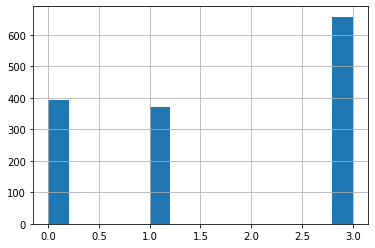

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

df.Result.hist(bins=15)


On remarque qu'une équipe gagne en moyenne la moitié de ses matchs à domicile, ce qui montre bien que jouer dans son propre stade, avec ses supporters, confère un avantage à une équipe (sinon au aurait plutôt du 33%). 

Le nombre de défaites et de nuls et quant à lui à peu près le même.


In [ ]:
df.describe()

,Result
count,1419.000000
mean,1.649753
std,1.306630
min,0.000000
25%,0.000000
50%,1.000000
75%,3.000000
max,3.000000



Passons maintenant à la création de nos nouvelles colonnes.
Celles- ci, sont rappelons-le : 

*   Le nombre de points de l'equipe à domicile AVANT de jouer le match
*   Le nombre de points de l'equipe à l'extérieur AVANT de jouer le match
*   La forme de l'equipe à domicile AVANT de jouer le match
*   La forme de l'equipe à domicile AVANT de jouer le match

Or, dans notre DatFrame, nous ne disposons que du résultat associé à chaque match. Nous allons donc devoir nous servir de l'historique des matchs et des résultats pour pouvoir recréer des colonnes qui dépendraient de tout ce qu'il s'est passé avant chaque match.

Commençons par le nombre de points des equipes : nous allons plutôt prendre le nombre de points moyen obtenu par chaque équipe : cela nous permettra de "normaliser" nos données afin que les coefficients puissent rester cohérents.
Nous essayerons tout de même de prendre le nombre de points bruts en partie 3 afin de voir si cela change nos résultats. 

Nous voulions tout d'abord essayer de passer par des groupby, mais un problème se pose à nous : il faut à la fois compter les points d'une equipe quand celle-ci joue à domicile et quand celle-ci joue à l'éxterieur. 

Il faudrait donc créer un nouveau data frame en inversant HomeTeam et AwayTeam puis le mixer avec notre premier dataframe, pour enfin lui appliquer une dérivée de cusum qui consisterai en un cummean, fonction qui n'existe pas dans pandas.

 La tâche nous semble compliquée, même si en creusant plus en profondeur nous pourrions peut-être abouttir, en témoigne ce premier essai concluant.

In [ ]:
display(df.groupby('HomeTeam')['Result'].cumsum())

0         0
1         1
2         3
3         3
4         0
       ... 
1414    141
1415     53
1416    120
1417    124
1418    126
Name: Result, Length: 1419, dtype: int64

Nous allons donc procéder à l'aide de boucles for, dans un soucis de simplicité. Commençons d'abord à créer les colonnes des nombres de points des deux equipes avant le match.

In [ ]:
df['PtsHomeTeam'] = np.zeros(len(df)) # Création des nouvelles colonnes que nous allons remplir avec des boucles
df['PtsAwayTeam'] = np.zeros(len(df))

for team in df.drop_duplicates(['HomeTeam'])['HomeTeam']: # Nous procédons équipe par équipe
  
  average_pts_team = 1.39 # On initilise à 1.39, qui est le nombre moyen de points pris par match en moyenne dans tout le championnat. 
  # En effet, en commençant, on ne sait rien sur aucun équipe, à part que celle-ci joue en Ligue 1 et a donc en moyenne pris 1.39 point en moyenne lors de ses derniers matchs.
  # (C'est différent de notre 1.65 obtenu avec describe(), qui correspond au nombre moyen de points pris à domicile.)

  nb_matches = 1 # On considère que ce 1.39 correspond à un match "genèse". On fixe donc le compteur à 1.

  for k in range(len(df)): # Pour chaque équipe, on parcourt le dataframe pour compter ses points. Le nombre d'equipes étant faible, nous pouvons nous le permettre sans que cela prenne un temps d'exécution trop long.

    if df['HomeTeam'].iloc[k] == team : 
      
      df['PtsHomeTeam'].iloc[k] = average_pts_team # on remplit la colonne du dataframe correpondante
       
      r = df['Result'].iloc[k] # on extrait le résultat afin de préparer le prochain remplissage de colonne

      average_pts_team = (average_pts_team*nb_matches + r)/(nb_matches+1) # à l'aide du résultat, on obtient le prochain nombre de points moyen qui viendra
      
      nb_matches = nb_matches+1
    
    if df['AwayTeam'].iloc[k] == team : # Pour chaque equipe on doit tester la colonne domicile ET la colonne extérieur pour bien compter tous les points au fur et à mesure.
      
      df['PtsAwayTeam'].iloc[k] = average_pts_team

      r = df['Result'].iloc[k]

      pts = (1/2)*r**2 - (5/2)*r + 3 # Attention, il faut bien appliquer une fonction à r car ici on compte les points de l'equipe à l'extérieur. Cette fonction est la fonction la plus simple vérifiant f(3)=0, f(1)=1, f(0)=3.
      
      average_pts_team = (average_pts_team*nb_matches + pts)/(nb_matches+1) 
      
      nb_matches = nb_matches+1

    if nb_matches >= 39 : 
      nb_matches = 1 

      # Les deux dernières lignes servent à réinitialiser le nombre de points obtenus. En effet, à la fin de chaque championnat, une équipe change beaucoup avec le marché des transferts.
      # Chaque equipe joue 38 matchs en une anné de championnat (sauf en 2019 à cause du covid où le championnat s'est arrêté prématurément, mais ça n'a pas d'impact ici)
      # Au bout de 38 matchs, on réinitalise le compteur. Ici, il faut que nb_matches >= 39 comme on a commencé à 1.

      # Cependant, le compteur n'est pas totalement réinitailisé à proprement parler. En effet, si on voulait faire totalement table rase du passé,
      # On entrerait n = 0 en initialisation et à la fin du programme. Ici, ce n = 1 permet de garder un lien d'une saison à l'autre : tout ce qu'il s'est passé
      # en 2018 se matérialisera sous la forme d'un match supplémentaire en 2019 dans le comptage de la moyenne par match. Il permet de faire le lien d'une saison à l'autre.
      
      # Pourquoi fait-on cela ? Une saison de championnar n'est pas totalement indépendante de la précédente, et donc symboliser le championnat de 2018 sous la forme d'un match 0 de la saison 2019
      # permet de rendre compte de cette continuité entre les saisons : les équipes ne sont pas totalement renouvelées d'une saison à l'autre, les entraineurs, le budget, le fonctionnement du club
      # restent les mêmes. 

      # Au final, cela permettra à notre modèle d'avoir des données plus réalistes. Repartir de 0 à chaque nouvelle saison rendrait notre modèle final moins précis.
      # Cependant, nous avons ici choisi de pondérer l'année passée à un seul match, ce qui finalement a un effet assez faible sur nos resultats.
    
display(df)


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,Date,HomeTeam,AwayTeam,Result,PtsHomeTeam,PtsAwayTeam
0,12/08/16,Bastia,Paris SG,0,1.390000,1.390000
1,12/08/16,Monaco,Guingamp,1,1.390000,1.390000
2,13/08/16,Bordeaux,St Etienne,3,1.390000,1.390000
3,13/08/16,Caen,Lorient,3,1.390000,1.390000
4,13/08/16,Dijon,Nantes,0,1.390000,1.390000
...,...,...,...,...,...,...
1414,07/03/2020,Nice,Monaco,3,1.409741,1.463475
1415,07/03/2020,Reims,Brest,3,1.408782,1.263929
1416,08/03/2020,St Etienne,Bordeaux,1,1.097476,1.324588
1417,08/03/2020,Rennes,Montpellier,3,1.727583,1.483823


On remarque qu'au début des colonnes, nous obtenons des 1,39 pour tout le monde : c'est ce à quoi on s'attendait au vu de notre initialisation. 

Maintenant, essayons d'implémenter des colonnes qui renvoient les états de forme des deux équipes. En effet, la moyenne des points obtenus par match sur une saison est finalement une donnée assez faible. Il peut arriver que l'equipe sois en manque de confiance, que l'entraîneur d'une équipe change, que la tactique change...et ces faits qui jouent sur le court-terme peuvent en partie être renvoyés par cet indicateur de forme des équipes. 

Ici, nous allons considérer que la forme d'une équipe correspond aux points moyens obtenus par match uniquement sur ses 5 derniers matchs. (5 étant un nombre abritraire, mais généralement celui choisi pour toutes les analyses dans le milieu).

Pour implémenter ces colonnes, encore plus complexes que les précédentes, il nous semble inévitable de repasser par des boucles for.

In [ ]:
df['FormHomeTeam'] = np.zeros(len(df))

df['FormAwayTeam'] = np.zeros(len(df)) # Comme la dernière fois, on commence par créer des colonnes vierges pour accueillir nos données.

for team in df.drop_duplicates(['HomeTeam'])['HomeTeam']: # Une fois de plus on procède équipe par équipe.

  last_results = 1.39*np.ones(5) # Pour chaque équipe, on créée un vecteur qui retrace ses 5 derniers resultats.
  # Comme la dernière fois, on initilise à 1,39, qui est le nombre moyen de points pris par match en moyenne dans tout le championnat.

  for k in range(len(df)): # Comme la dernière fois, on parcourt tout le data frame à la recherche de matchs qui concernent notre équipe.

    if df['HomeTeam'].iloc[k] == team :

      form = np.mean(last_results) # La forme de chaque equipe correspond alors à la moyenne de notre vecteur last_results.

      df['FormHomeTeam'].iloc[k] = form

      r = df['Result'].iloc[k]

      last_results = np.delete(np.insert(last_results, [0], r) ,[5]) # On commence par insérer notre résultat le plus actuel en première position de notre vecteur, 
      # puis on supprime la dernière valeur, qui est alors le résultat du N-6 ème match joué.
    
    if df['AwayTeam'].iloc[k] == team :
      
      form = np.mean(last_results)

      df['FormAwayTeam'].iloc[k] = form

      r = df['Result'].iloc[k]

      pts = (1/2)*r**2 - (5/2)*r + 3
  
      last_results = np.delete(np.insert(last_results, [0], pts) ,[5])

# Ici, on décide de ne pas réinitialiser le compteur entre chaque saison. Ainsi, nous pouvons garder une trace de la continuité entre deux saisons de championnat. 
# Comme nous l'avons dit précément, une saison de championnat n'est pas totalement indépendante de la précédente, et notre indicateur de forme permet de capter une plus grande partie de cet effet que précément.

display(df)



/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,Date,HomeTeam,AwayTeam,Result,PtsHomeTeam,PtsAwayTeam,FormHomeTeam,FormAwayTeam
0,12/08/16,Bastia,Paris SG,0,1.390000,1.390000,1.39,1.39
1,12/08/16,Monaco,Guingamp,1,1.390000,1.390000,1.39,1.39
2,13/08/16,Bordeaux,St Etienne,3,1.390000,1.390000,1.39,1.39
3,13/08/16,Caen,Lorient,3,1.390000,1.390000,1.39,1.39
4,13/08/16,Dijon,Nantes,0,1.390000,1.390000,1.39,1.39
...,...,...,...,...,...,...,...,...
1414,07/03/2020,Nice,Monaco,3,1.409741,1.463475,1.20,2.20
1415,07/03/2020,Reims,Brest,3,1.408782,1.263929,1.20,1.20
1416,08/03/2020,St Etienne,Bordeaux,1,1.097476,1.324588,0.20,1.20
1417,08/03/2020,Rennes,Montpellier,3,1.727583,1.483823,1.40,1.40


On remarque alors que la forme semble bien être un indicateur assez différent du nombre de points, bien que corrélé. Par exemple, à la fin du championnat de 2019, on voit que Saint-Etienne réalisait une assez mauvaise performance (seulement 1,09 point de pris par match en moyenne) mais était dans une forme encore plus catastrophique ! (1 point seuleument gagné sur ses 5 derniers matchs).
On voit aussi que Lille et Rennes sont au coude à coude en nombre de points dans le championnat, mais Lille étant beaucoup plus en forme, peut-être qu'ils auraient devancé Rennes si le championnat n'avait pas été interrompu.

Nous pouvons alors supprimer nos lignes d'initialisation, qui ne reflètent pas forcément des informations intéréssantes (ici, une absence d'information). Bien que cela a été utile pour construire nos colonnes, baser notre modèle sur celles-ci pourrait entraîner des biais.


In [ ]:
df = df.drop(index = np.arange(10))
df = df.set_index(np.arange(len(df)))
display(df)

,Date,HomeTeam,AwayTeam,Result,PtsHomeTeam,PtsAwayTeam,FormHomeTeam,FormAwayTeam
0,19/08/16,Lyon,Caen,3,2.195000,2.195000,1.712,1.712
1,20/08/16,Angers,Nice,0,0.695000,2.195000,1.112,1.712
2,20/08/16,Lille,Dijon,3,0.695000,0.695000,1.112,1.112
3,20/08/16,Lorient,Bastia,0,0.695000,0.695000,1.112,1.112
4,20/08/16,Nantes,Monaco,0,2.195000,1.195000,1.712,1.312
...,...,...,...,...,...,...,...,...
1404,07/03/2020,Nice,Monaco,3,1.409741,1.463475,1.200,2.200
1405,07/03/2020,Reims,Brest,3,1.408782,1.263929,1.200,1.200
1406,08/03/2020,St Etienne,Bordeaux,1,1.097476,1.324588,0.200,1.200
1407,08/03/2020,Rennes,Montpellier,3,1.727583,1.483823,1.400,1.400


In [ ]:
df.describe()

,Result,PtsHomeTeam,PtsAwayTeam,FormHomeTeam,FormAwayTeam
count,1409.000000,1409.000000,1409.000000,1409.00000,1409.000000
mean,1.649397,1.366806,1.394589,1.34464,1.401151
std,1.306344,0.482027,0.485403,0.66118,0.652948
min,0.000000,0.180800,0.176988,0.00000,0.000000
25%,0.000000,1.043397,1.068667,0.80000,0.878000
50%,1.000000,1.303361,1.333562,1.31200,1.400000
75%,3.000000,1.586875,1.622869,1.80000,1.800000
max,3.000000,2.960195,2.962849,3.00000,3.000000


Ces statistiques descriptives nous permettent de tester la cohérence de nos résultats, pour voir si on a bien construit nos colonnes. On observe qu'en moyenne le nombre de points par match moyen des equipes et leur forme moyenne sont presque identiques : on pouvait s'y attendre, étant donné que les effets de forme se compensent quand on considère leur moyenne. 

Cela dit, l'écart-type de la forme est plus important, ce à quoi on s'attendait (plus de variations de forme que de variationns de points moyens sur toute la saison).

Il peut sembler étrange que la moyenne de points des équipes qui jouent à l'extérieur soit plus élevée que la moyenne de points des équipes qui jouent à domicile. Cela peut s'expliquer par le fait que quand on équipe joue à domicile, elle a probablement joué un match de plus à l'extérieur avant (une fois sur deux) qu'elle perd plus souvent comme on l'a vu dans le describe(). 
A l'inverse, une equipe qui joue à l'extérieur a probablement joué à domicile avant et aborde donc le match avec plus de points en moyenne (même si on le voit, l'effet est assez infime). Cet effet est donc logiquement exacerbé sur les formes, plus variables.

Nos resultats sont donc bien cohérents.





Avec ces données beaucoup plus riches, nous allons pouvoir essayer de voir graphiquement les effets de nos variables sur le résultat.

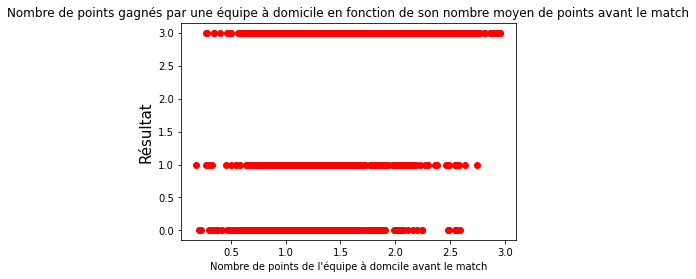

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(df['PtsHomeTeam'],df['Result'],'ro')
plt.title('Nombre de points gagnés par une équipe à domicile en fonction de son nombre moyen de points avant le match')
plt.xlabel("Nombre de points de l'équipe à domcile avant le match")
plt.ylabel('Résultat', size=15)
plt.show()



Il est assez difficile de distinguer grand chose sur ce graphique, car comme notre Y ne prend que 3 valeurs, celles-ci s'accumulent sur le graphique. Il semble tout de même y avoir une correlation entre le nombre de points moins obtenu par une équipe à domicile avant le match et le résultat du match : on voit que le trait rouge se décale vers la droite en montant, ce qui veut dire que si une equipe à domicile gagne, elle a plus régulièrement des points moyens par match élevés.
Pour s'en convaincre, utilisons l'argument lm de seaborn : 

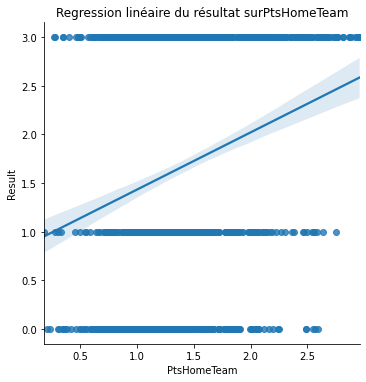

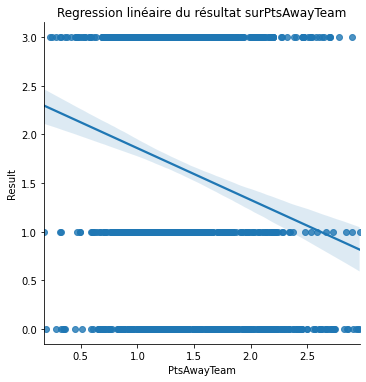

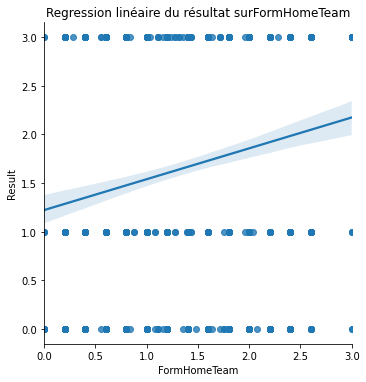

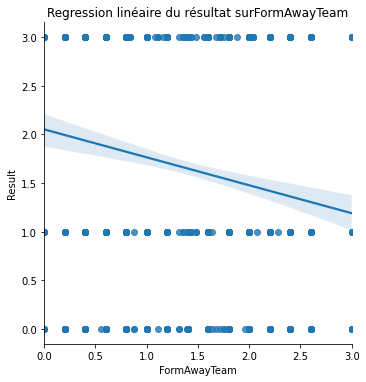

In [ ]:
import seaborn as sns
for k in ["PtsHomeTeam", "PtsAwayTeam", "FormHomeTeam", "FormAwayTeam"]:
  sns.lmplot(data=df, x=k, y="Result")
  plt.title('Regression linéaire du résultat sur'+ k)


On peut désormais identifier les correlations auxquelles on s'attendait : on voit bien que plus une équipe à domicile est en forme ou a gagné de points durant le championnat, plus elle a de chances de gagner son prochain match. A l'inverse, plus l'equipe à l'éxterieur est en forme ou a gagné de points, plus il y a de chance pour que l'equipe à domicile perde.




# B)Modélisation

Nous allons désormais pouvoir passer à la construction de notre modèle ! 

Il s'agit ici clairement d'un problème de classification , Y étant discret (il ne prend comme valeurs que 3, 1 et 0). On va donc pouvoir utiliser le module de regression logistique de sklearn.

Commençons par séparer nos datasets en train et test.

In [ ]:
from sklearn.model_selection import train_test_split

X = df[['PtsHomeTeam', 'PtsAwayTeam', 'FormHomeTeam', 'FormAwayTeam']]
Y = df['Result']

from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state=7)

print(X_train.shape, X_test.shape)

(986, 4) (423, 4)


Maintenant, nous pouvons entraîner notre régresseur :

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Commençons par vérifier si notre modèle marche sur les premières données de X_test. Regardons ce qu'il prédit pour les 5 premiers matchs de X_test.

In [ ]:
display(X_test.head().index, lr.predict(X_test[:5]))

Int64Index([1083, 313, 734, 284, 671], dtype='int64')

array([3, 3, 3, 0, 0])

In [ ]:
# Ce qui correspond aux matchs :
display(df.iloc[1083], df.iloc[313], df.iloc[734], df.iloc[284], df.iloc[671])

Date            28/04/2019
HomeTeam              Caen
AwayTeam             Dijon
Result                   3
PtsHomeTeam       0.794106
PtsAwayTeam       0.860471
FormHomeTeam           1.2
FormAwayTeam           1.4
Name: 1083, dtype: object

Date            15/04/17
HomeTeam            Nice
AwayTeam           Nancy
Result                 3
PtsHomeTeam      2.16333
PtsAwayTeam     0.981515
FormHomeTeam         2.2
FormAwayTeam         0.6
Name: 313, dtype: object

Date            12/05/18
HomeTeam           Lille
AwayTeam           Dijon
Result                 3
PtsHomeTeam     0.978787
PtsAwayTeam      1.24282
FormHomeTeam         1.4
FormAwayTeam         1.4
Name: 734, dtype: object

Date            18/03/17
HomeTeam          Nantes
AwayTeam            Nice
Result                 1
PtsHomeTeam      1.27967
PtsAwayTeam      2.14633
FormHomeTeam         1.6
FormAwayTeam         2.2
Name: 284, dtype: object

Date             31/03/18
HomeTeam            Dijon
AwayTeam        Marseille
Result                  0
PtsHomeTeam       1.25756
PtsAwayTeam       1.95566
FormHomeTeam          1.4
FormAwayTeam          1.4
Name: 671, dtype: object

Les résultats sont intéréssants : on voit qu'on prédit bien l'issue de quatre matchs sur cinq. Le seul match que nous prédisons mal est un match nul, résultat assez diffciles à prédire car très incertains. Le match Lille Dijon pouvait d'ailleurs paraître assez incertain, les données brutes laissent même présager un certain avantage de Dijon, pourtant notre modèle ne s'est pas trompé et a bien prédit la victoire de Lille. C'est prometteur.

De plus, il ne semble pas se dégager d'apétence de notre algorithme à miser sur la victoire de l'equipe à domicile. En effet, nous avons vu que c'est généralement l'équipe à domicile qui gagne, donc pourquoi se mouiller ? Il faut que nous fassions attention à ce que l'algorithme ne renvoie pas 3 trop souvent, comme c'est le résultat le plus probable. Mais ici, nous prédisons tout de même deux victoires à l'extérieur, ce qui laisse présager que notre modèle s'adapte bien à chaque situation.

Pour pouvoir tester si notre modèle est vraiment bon, nous allons utiliser les metriques d'évaluation proposées par sklearn.



In [ ]:
from sklearn.metrics import classification_report

Y_pred = lr.predict(X_test)
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.49      0.43      0.46       111
           1       0.00      0.00      0.00       125
           3       0.49      0.86      0.63       187

    accuracy                           0.49       423
   macro avg       0.33      0.43      0.36       423
weighted avg       0.35      0.49      0.40       423



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Nous remarquons tout de suite que nous prédisons très mal les matchs nuls : sur les 125, nous n'en avons bien prédit aucun...Nous sommes donc très mauvais pour prédire les matchs nuls. Cependant, pour les victoires et les défaites, les résultats sont encourageants. 

Ce qu'il est important de regarder, dans le cadre d'un pari, c'est surtout la precision, c'est à dire la pertinence de l'information remontée.

En effet, le recall nous indique ici que 86% des victoires à domicile ont bien été prédites par notre modèle. Cela ne nous intéresse que peu, dans le sens ou l'objectif d'un pari n'est pas de deviner tous les matchs, mais plutôt de ne pas se tromper sur ceux qu'on essaye de prédire.

Ici, nous avons une donnée très intéréssante : notre précision pour prédire les victoires des équipes à l'extérieur semble assez élevée. En effet, la proportion de victoires à l'extérieur ne correspond qu'à environ 1/4 ou au plus 1/3 des matchs, or 49% de nos paris "l'equipe à l'extérieur gagne" s'avèrent juste. Nous sommes donc bien meilleurs qu'en pariant juste au hasard. On pourrait donc essayer d'adopter une stratégie de paris ne consistant à parier que sur les victoires à l'extérieur, quand c'est le résultat prédit par notre algorithme.

brouillon : essayer de faire plus de graphiques

**PARTIE 2 : MACHINE LEARNING VS BOOKMAKERS**





Dans cette partie, nous allons confronter nos résultats à la réalité. En effet, il sera toujours impossible de prédire à la perfection des matchs de football, étant donné que c'est un sport rempli d'incertitude où la chance joue beaucoup. 
Ainsi, il est sera toujours impossible d'obtenir des scores des métriques d'évaluation très satisfaisantes, surtout au vu du peu de données dont l'on dispose avant chaque match. C'est notament ce qui justifie l'existence des paris sportifs : c'est justement parce qu'il y a une part inimputable de chance que des bookmakers (les personnes qui proposent les paris), parviennent à s'enrichir.

Ainsi, si nous prenons les bookmakers pour référence, on peut considérer que nos résultats seraient bons à partir du moment où ils parviendrait à mieux estimer la loi de probabilité de nos résultats Y, sachant X, les données d'avant chaque match, que les bookmakers. Notre régression logistique est une tentative d'estimer cette loi, et nous allons pouvoir voir si nos résultats nous permettent de gagner de l'argent, sur le moyen terme.


**A) Qu'est ce qu'une côte ?**

Tout d'abord, afin de bien expliciter notre objectif et notre manière de faire, nous allons revenir à la base. Dans cette partie, nous allons réexpliquer ce qu'est une côte et le fonctionnement des paris sportifs.

Une cote représente le gain potentiel que le parieur peut recevoir en misant 1 euro si son pari est gagnant. C’est le site de pari sportif qui la détermine. Il faut savoir qu’une cote est nombre décimal (1.82 ou 2.13 par exemple) qui ne peut être inférieur à 1.

Voici un petit programme qui détaille le calcul de nos gains :



In [ ]:
def resultat_pari(mise, côte, resultat_predit, resultat_reel) : 

  if resultat_predit == resultat_reel :
     return(mise*côte-mise) # On empoche nos gains potentiels c'est à dire notre mise fois la côte, moins notre investissement initial, c'est à dire la mise
    
  else :
    return(-mise) 

print("Voici un exemple pour mieux comprendre : si jamais je prédis bien la victoire de Paris contre Dijon, côté à 1.17, et que j'ai misé 50 euros, j'obtiens :", resultat_pari(50, 1.17, 3, 3), "euros.")
print("Cependant, si Paris avait fait match nul, on aurait perdu", abs(resultat_pari(50, 1.17, 3, 1)), "euros.")

Voici un exemple pour mieux comprendre : si jamais je prédis bien la victoire de Paris contre Dijon, côté à 1.17, et que j'ai misé 50 euros, j'obtiens : 8.5 euros.
Cependant, si Paris avait fait match nul, on aurait perdu 50 euros.


Attention, il faut ici bien faire une différence entre bénéfice et gain. Le bénéfice est ce qu'on empoche en plus de notre mise de départ, c'est à dire nos bénéfices "nets", tandis que le gain ne représente que ce qui est gagné de manière brute.

C'est pour cela qu'une côte est forcément supérieure à 1 : nos bénéfices sont égaux à (côte-1)*mise si jamais on prédit bien l'issue du match. Donc il faut forcément que la côte soit supérieure à 1 pour qu'on puisse espérer gagner de l'argent.

On remarque aussi que plus la côte est grande, plus notre gain potentiel est grand. Ainsi, on se rend bien compte que plus une côte est proche de 1, plus il faut que nos probabilités de gagner soient fortes pour espérer être rentables.
A l'inverse, plus une côte est grande, plus on est prêt à prendre des risques et parier des résultats qui peuvent sembler improbables au vu de la récompense.
On voit donc clairement une relation décroissante entre la côte d'un évènement et sa probabilité.

De manière plus mathématique, la côte associée à un résultat est l'inverse de la probabilité que celui-ci se réalise. On a donc la relation : côte = 1 / probabilité.

(En réalité, pas tout a fait. On a plutôt côte = 85/(100*proba). En effet, pour que les bookmakers soient rentables, ils doivent se prendre une marge, qui est aujourd'hui d'à peu près 15%. On a alors un taux de retour joueur moyen de 85%).

**B ) Gagner face aux bookmakers**

Maintenant que nous comprenons mieux le système de côte, nous allons pouvoir essayer de nous confronter aux bookmakers. 

Le problème de notre régresseur est qu'il résoud un problème de classification. Ainsi, à partir des données avant match, notre régresseur prédit un résultat, sans donner plus de détails (nous surmonterons ce problème en partie C).

Nous pouvons utiliser différentes stratégies pour utiliser nos résultats. Par exemple, étant donné que notre precision score pour les victoires à l'éxterieur semble plutôt bon, on pourrait dire qu'on ne parie que quand notre régresseur prédit "0" comme résultat. Nous allons donc pouvoir tester plusieurs stratégies.

Ces stratégies, nous allons les tester sur les données 2020, que nous avons laissé de côté au début, afin d'être sûr d'éviter de biaiser nos données.

Commençons par préparer le dataset :

In [ ]:
df_2020 = pd.concat([data_ligue_1_2019, data_ligue_1_2020]) # On concatène les données 2019 et 2020 afin de ne pas devoir réinitialiser nos colonnes Formes et Points qui tiennent en partie compte des championnats précédents. 
# On effacera les données 2019 par la suite.

df_2020 = df_2020.rename(columns = {'FTR': 'Result'})
df_2020['Result'] = df_2020['Result'].apply(Resultat)
df_2020 = df_2020.set_index(np.arange(len(df_2020)))

df_2020['PtsHomeTeam'] = np.zeros(len(df_2020)) 
df_2020['PtsAwayTeam'] = np.zeros(len(df_2020))
df_2020['FormHomeTeam'] = np.zeros(len(df_2020))
df_2020['FormAwayTeam'] = np.zeros(len(df_2020))

limite = len(data_ligue_1_2019) # Ici, on va explicitement se demander pour chaque équipe si son match correspond au championnat actuel ou au précédent. 
# Nous ne pouvons plus simplement regarder le nombre de matchs, étant donné que quand le championnat s'est interrompu, toutes les équipes n'avait pas fait le même nombre de matchs.

for team in df_2020.drop_duplicates(['HomeTeam'])['HomeTeam']: 
  
  average_pts_team = 1.39 
  nb_matches = 1 
  Switch = False
  last_results = 1.39*np.ones(5)

  for k in range(len(df_2020)): 

    if df_2020['HomeTeam'].iloc[k] == team : 
           
      if (k > limite and Switch == False) : # Ces lignes diffèrents du programme précédent car toutes les équipes n'ont pas joué le même nombre de matchs avant l'interuption de championnat
         nb_matches = 1 
         Switch = True # Switch = True equivaut au fait qu'on soit au championnat 2020
      
      df_2020['PtsHomeTeam'].iloc[k] = average_pts_team
       
      r = df_2020['Result'].iloc[k]

      average_pts_team = (average_pts_team*nb_matches + r)/(nb_matches+1)
      
      nb_matches = nb_matches+1

      form = np.mean(last_results) 

      df_2020['FormHomeTeam'].iloc[k] = form

      last_results = np.delete(np.insert(last_results, [0], r) ,[5])  
    
    if df_2020['AwayTeam'].iloc[k] == team : 

      if k > limite and Switch == False :
         nb_matches = 1 
         Switch = True
      
      df_2020['PtsAwayTeam'].iloc[k] = average_pts_team

      r = df_2020['Result'].iloc[k]

      pts = (1/2)*r**2 - (5/2)*r + 3 
      
      average_pts_team = (average_pts_team*nb_matches + pts)/(nb_matches+1) 
      
      nb_matches = nb_matches+1      

      form = np.mean(last_results)

      df_2020['FormAwayTeam'].iloc[k] = form
  
      last_results = np.delete(np.insert(last_results, [0], pts) ,[5])

df_2020 = df_2020.drop(index = np.arange(limite))
df_2020 = df_2020.set_index(np.arange(len(df_2020)))
    
display(df_2020)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,Result,HTHG,HTAG,HTR,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,PSH,PSD,PSA,WHH,WHD,WHA,VCH,VCD,...,BWCA,IWCH,IWCD,IWCA,PSCH,PSCD,PSCA,WHCH,WHCD,WHCA,VCCH,VCCD,VCCA,MaxCH,MaxCD,MaxCA,AvgCH,AvgCD,AvgCA,B365C>2.5,B365C<2.5,PC>2.5,PC<2.5,MaxC>2.5,MaxC<2.5,AvgC>2.5,AvgC<2.5,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA,PtsHomeTeam,PtsAwayTeam,FormHomeTeam,FormAwayTeam
0,F1,21/08/2020,18:00,Bordeaux,Nantes,0,0,1,0,0,D,5,6,1,1,10,15,2,3,2,3,1,0,2.40,3.00,3.25,2.40,3.00,3.30,2.50,2.80,3.25,2.48,3.03,3.33,2.45,3.0,3.10,2.45,2.88,...,2.95,2.70,2.80,3.00,2.71,2.97,3.02,2.62,3.0,2.90,2.63,2.88,3.00,2.80,3.08,3.25,2.65,2.93,3.01,2.75,1.44,2.89,1.46,2.90,1.49,2.79,1.43,0.00,1.86,2.04,1.85,2.07,1.90,2.24,1.82,2.05,1.323793,1.323793,1.20,1.0
1,F1,22/08/2020,16:00,Dijon,Angers,0,1,0,0,1,A,9,12,1,4,15,8,3,9,0,0,0,0,2.70,3.10,2.80,2.75,3.00,2.80,2.75,2.90,2.80,2.79,3.09,2.84,2.70,3.1,2.75,2.70,3.00,...,2.45,3.30,2.85,2.45,3.36,3.07,2.44,3.25,3.0,2.38,3.40,2.90,2.38,3.46,3.17,2.53,3.30,3.02,2.39,2.75,1.44,2.72,1.50,2.86,1.56,2.61,1.49,0.25,1.86,2.07,1.85,2.06,1.88,2.08,1.83,2.03,1.082414,1.392759,1.20,1.8
2,F1,22/08/2020,20:00,Lille,Rennes,1,1,1,1,0,H,5,16,1,3,12,16,4,2,0,1,1,1,2.30,3.20,3.30,2.30,3.20,3.30,2.30,3.00,3.35,2.30,3.22,3.47,2.25,3.2,3.30,2.25,3.13,...,4.33,1.90,3.20,4.40,1.92,3.47,4.52,1.85,3.4,4.40,1.87,3.40,4.40,1.97,3.55,4.70,1.89,3.38,4.38,2.20,1.66,2.33,1.66,2.38,1.76,2.26,1.64,-0.50,1.90,2.03,1.92,2.00,1.95,2.05,1.89,1.96,1.737586,1.772069,2.40,2.0
3,F1,23/08/2020,12:00,Monaco,Reims,2,2,1,1,2,A,22,9,5,3,8,14,8,1,1,3,0,0,1.90,3.40,4.33,1.91,3.50,4.20,1.95,3.25,4.20,1.95,3.53,4.24,1.88,3.4,4.20,1.87,3.25,...,4.20,1.95,3.20,4.30,1.95,3.43,4.42,1.85,3.5,4.33,1.90,3.30,4.40,1.98,3.64,4.71,1.92,3.37,4.25,2.30,1.61,2.40,1.63,2.43,1.69,2.29,1.62,-0.50,1.95,1.98,1.95,1.97,1.96,1.99,1.92,1.92,1.427241,1.461724,1.60,1.6
4,F1,23/08/2020,14:00,Lorient,Strasbourg,3,1,3,0,1,A,10,7,7,1,17,10,6,1,3,2,0,0,2.50,3.20,3.00,2.60,3.20,2.85,2.55,2.95,2.95,2.62,3.19,2.96,2.50,3.2,2.88,2.55,3.00,...,3.10,2.50,2.95,3.15,2.45,3.15,3.25,2.40,3.1,3.10,2.40,3.00,3.20,2.54,3.30,3.26,2.43,3.09,3.15,2.50,1.53,2.52,1.57,2.52,1.67,2.40,1.58,-0.25,2.08,1.85,2.09,1.83,2.14,1.86,2.07,1.80,1.390000,1.406786,1.39,1.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,F1,06/12/2020,14:00,Bordeaux,Brest,1,0,3,0,0,D,21,8,6,3,10,11,8,2,0,3,0,0,2.05,3.50,3.60,2.15,3.30,3.50,2.15,3.35,3.40,2.17,3.51,3.62,2.10,3.4,3.50,2.05,3.40,...,3.30,2.20,3.35,3.35,2.22,3.55,3.43,2.20,3.4,3.25,2.15,3.50,3.30,2.26,3.62,3.45,2.18,3.43,3.30,1.80,2.00,1.81,2.09,1.88,2.15,1.80,2.01,-0.25,1.91,2.02,1.92,2.01,1.95,2.02,1.89,1.95,1.359417,1.478488,1.40,1.8
124,F1,06/12/2020,14:00,Dijon,St Etienne,0,0,1,0,0,D,6,7,1,2,15,13,7,4,0,1,0,0,3.00,3.40,2.37,3.00,3.40,2.35,2.95,3.30,2.40,3.07,3.56,2.41,2.90,3.4,2.38,2.90,3.30,...,2.00,3.55,3.45,2.10,3.64,3.67,2.10,3.50,3.5,2.05,3.50,3.50,2.05,3.75,3.72,2.15,3.55,3.53,2.05,1.80,2.00,1.85,2.06,1.90,2.07,1.82,1.98,0.50,1.83,2.10,1.84,2.10,1.85,2.11,1.80,2.05,0.621724,0.929416,1.00,0.2
125,F1,06/12/2020,14:00,Nantes,Strasbourg,0,4,0,0,2,A,14,13,2,9,13,13,7,3,3,2,0,0,2.15,3.30,3.50,2.20,3.30,3.40,2.20,3.25,3.40,2.19,3.66,3.41,2.15,3.4,3.30,2.10,3.30,...,3.40,2.25,3.25,3.30,2.31,3.45,3.34,2.25,3.3,3.25,2.25,3.40,3.20,2.33,3.50,3.40,2.25,3.34,3.24,2.00,1.80,2.02,1.88,2.09,1.92,1.98,1.82,-0.25,1.99,1.94,1.98,1.94,2.00,1.94,1.94,1.90,1.109417,0.646676,1.00,0.8
126,F1,06/12/2020,16:00,Reims,Nice,0,0,1,0,0,D,11,12,2,4,12,13,6,6,1,2,0,0,2.50,3.40,2.80,2.45,3.30,2.95,2.55,3.25,2.80,2.58,3.48,2.88,2.55,3.3,2.75,2.50,3.25,...,3.10,2.45,3.15,3.05,2.49,3.25,3.19,2.35,3.3,3.00,2.40,3.20,3.10,2.51,

En appliquant les mêmes programmes que précément, on parvient à obtenir des données 2020 prêtes à être traitées ! On remarque notament qu'avoir concatené les données 2019 au début nous permet d'avoir des indices de forme qui ne commençent pas à 1.39 !

Comme évoqué au début, nous avons des données sur les côtes au moment du match. Nous allons donc, à chaque match, pouvoir jouer ce que notre régresseur prédit.

In [ ]:
df_2020_bet = df_2020

df_2020_bet['Prediction'] = lr.predict(pd.DataFrame(np.c_[df_2020['PtsHomeTeam'], df_2020['PtsAwayTeam'], df_2020['FormHomeTeam'], df_2020['FormAwayTeam']])) # Nous créons une colonne de prédiction

# Nous définissons une fonction pour savoir quelle côte choisir pour chacun de nos paris.
# Par soucis de simplicité, nous n'allons regarder que les côtes du site de pari 365, réputé pour proposer les côtes les plus intéréssantes.
# Nous pourrons modifier ce détail par la suite.

df_2020_bet['Côte'] = np.zeros(len(df_2020_bet)) # On crée une colonne qui répértorie les côtes associées à nos paris, se remplissant au fur et à mesure.
df_2020_bet['Gains'] = np.zeros(len(df_2020_bet)) # On créée une colonne de gains

for k in range(len(df_2020_bet)) : # Nous remplissons les colonnes de côtes et gains au fur et à mesure. Nous aurions pu passer par un apply, mais nous tenions à réutiliser
# notre fonction resultat_pari définie au début.

  resultat_predit = df_2020_bet['Prediction'].iloc[k] 
  resultat_reel = df_2020_bet['Result'].iloc[k]

  if resultat_predit == 3:

    côte = df_2020_bet['B365H'].iloc[k]
    df_2020_bet['Côte'].iloc[k] = côte 

  elif resultat_predit == 1:

    côte = df_2020_bet['B365D'].iloc[k]
    df_2020_bet['Côte'].iloc[k] = côte

  elif resultat_predit == 0:

    côte = df_2020_bet['B365A'].iloc[k]
    df_2020_bet['Côte'].iloc[k] = côte
  
  df_2020_bet['Gains'].iloc[k] = resultat_pari(1, côte, resultat_predit, resultat_reel)


display(df_2020_bet[['HomeTeam', 'AwayTeam', 'Prediction', 'Côte', 'Result', 'Gains']])

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,HomeTeam,AwayTeam,Prediction,Côte,Result,Gains
0,Bordeaux,Nantes,3,2.40,1,-1.00
1,Dijon,Angers,3,2.70,0,-1.00
2,Lille,Rennes,3,2.30,1,-1.00
3,Monaco,Reims,3,1.90,1,-1.00
4,Lorient,Strasbourg,3,2.50,3,1.50
...,...,...,...,...,...,...
123,Bordeaux,Brest,3,2.05,3,1.05
124,Dijon,St Etienne,3,3.00,1,-1.00
125,Nantes,Strasbourg,3,2.15,0,-1.00
126,Reims,Nice,0,2.80,1,-1.00


Il ne nous reste plus qu'à faire un somme sur nos gains pour voir combien on aurait gagné d'argent en 2020 si on avait misé 1 euros sur chaque match, sur le résultat que nous prédit notre régresseur.

In [ ]:
sum(df_2020_bet['Gains'].dropna())

-8.48

In [ ]:
sum(df_2020_bet[df_2020_bet['Prediction'] == 0]['Gains'].dropna())

-0.4200000000000008

In [ ]:
df_new = df_2020_bet[df_2020_bet['Prediction'] == 0]
sum(df_new[df_new['Côte'] > 2.2]['Gains'].dropna())

0.9499999999999997

In [ ]:
df_2020.groupby('HomeTeam')['Result'].mean().sort_values()


HomeTeam
Dijon          0.571429
Nimes          0.571429
Strasbourg     0.666667
Reims          0.666667
Lorient        0.666667
Nice           1.166667
St Etienne     1.166667
Nantes         1.333333
Rennes         1.428571
Angers         1.428571
Metz           1.428571
Marseille      1.600000
Montpellier    1.714286
Bordeaux       1.714286
Lens           1.833333
Brest          2.000000
Paris SG       2.166667
Lyon           2.333333
Monaco         2.428571
Lille          2.428571
Name: Result, dtype: float64

In [ ]:

print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.49      0.43      0.46       111
           1       0.00      0.00      0.00       125
           3       0.49      0.86      0.63       187

    accuracy                           0.49       423
   macro avg       0.33      0.43      0.36       423
weighted avg       0.35      0.49      0.40       423



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Partie 3 : Optimisation**

Nous obtenons donc des résultats moyennement encourageants. Nous allons essayer d'optimiser notre modèle et nos stratégies afin de voir si nous pouvons obtenir de meilleurs résultats.

Premièrement, attardons nous sur le problème des mauvaises prédiction de matchs nuls. Nous avions vu en partie 1 que notre modèle était catastrophique pour prédire les matchs nuls (aucun ne passait sur les 125 à prédire).

Essayons de regarder les métriques de notre modèle d'apprentissage : 

In [ ]:
Y_pred_train = lr.predict(X_train)
print(classification_report(Y_train, Y_pred_train))

              precision    recall  f1-score   support

           0       0.49      0.38      0.43       278
           1       0.00      0.00      0.00       243
           3       0.52      0.87      0.65       465

    accuracy                           0.52       986
   macro avg       0.34      0.42      0.36       986
weighted avg       0.38      0.52      0.43       986



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


On remarque que même dans le dataset d'apprentissage, notre modèle ne prédit bien aucun match nul.
Cela est un problème courant dans les problèmes de classification : notre modèle va avoir tendance à s'adapter aux probabilités "inhérentes" à chaque évènement. 
Ici, la probabilité qu'une équipe à domicile gagne est clairement plus élevée : nous avons vu que dans notre dataset, cela correspondait à 52% des observations. Ainsi, un modèle qui ne fait que prédire des victoires obtiendrait un 100% de recall sur les victoires et un recall total de 52%. c'est d'ailleurs exactement le weighted average du recall de notre modèle.
Essayons donc de voir le support de nos prédictions :

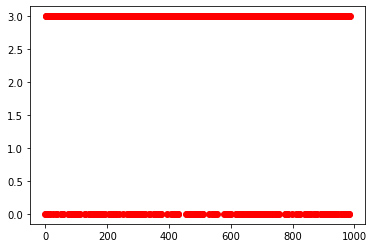

In [ ]:
plt.plot(Y_pred_train, 'ro')

On remarque immédiatement que notre modèle ne prédit aucun "1" donc aucun match nul. Cependant, il prédit tout de même des victoires à l'extérieur.

In [ ]:
display(1 - np.count_nonzero(Y_pred_train)/len(Y_pred_train))

0.2210953346855984

Il prédit 22% de victoires à l'extérieur, pour être précis. Ona a donc 78% de nos prédictions qui sont des victoires à domicile, ce qui est assez élevé.
Peut être que cette absence de prédictions de matchs nuls vient du fait que nos variables explicatives expliquent très mal le phénomène de match nul. Essayons de rajouter des variables explicatives à notre modèle. 
On pourrait par exemple rajouter une donnée qui serait le nombre de matchs nuls moyens réalisé par chaque équipe avant leur match. 
Tout d'abord, implémentons cette donnée dans df, à la manière de nos colonnes crées dans la partie 1.


In [ ]:
df['DrawsHomeTeam'] = np.zeros(len(df)) 
df['DrawsAwayTeam'] = np.zeros(len(df))

for team in df.drop_duplicates(['HomeTeam'])['HomeTeam']: 
  
  average_draws_team = 0.29
  nb_matches = 1

  for k in range(len(df)): 

    if df['HomeTeam'].iloc[k] == team : 
      
      df['DrawsHomeTeam'].iloc[k] = average_draws_team
       
      r = float(df['Result'].iloc[k]==1) # renvoie 1 si match nul, 0 sinon

      average_draws_team = (average_draws_team*nb_matches + r)/(nb_matches+1)
      
      nb_matches = nb_matches+1
    
    if df['AwayTeam'].iloc[k] == team : 
      
      df['DrawsAwayTeam'].iloc[k] = average_draws_team

      r = float(df['Result'].iloc[k]==1)

      average_draws_team = (average_draws_team*nb_matches + r)/(nb_matches+1) 
      
      nb_matches = nb_matches+1

    if nb_matches >= 39 : 
      nb_matches = 1 

    
display(df)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,Date,HomeTeam,AwayTeam,Result,PtsHomeTeam,PtsAwayTeam,FormHomeTeam,FormAwayTeam,DrawsHomeTeam,DrawsAwayTeam
0,19/08/16,Lyon,Caen,3,2.195000,2.195000,1.712,1.712,0.290000,0.290000
1,20/08/16,Angers,Nice,0,0.695000,2.195000,1.112,1.712,0.290000,0.290000
2,20/08/16,Lille,Dijon,3,0.695000,0.695000,1.112,1.112,0.290000,0.290000
3,20/08/16,Lorient,Bastia,0,0.695000,0.695000,1.112,1.112,0.290000,0.290000
4,20/08/16,Nantes,Monaco,0,2.195000,1.195000,1.712,1.312,0.290000,0.290000
...,...,...,...,...,...,...,...,...,...,...
1404,07/03/2020,Nice,Monaco,3,1.409741,1.463475,1.200,2.200,0.306969,0.270853
1405,07/03/2020,Reims,Brest,3,1.408782,1.263929,1.200,1.200,0.407775,0.367500
1406,08/03/2020,St Etienne,Bordeaux,1,1.097476,1.324588,0.200,1.200,0.193985,0.343935
1407,08/03/2020,Rennes,Montpellier,3,1.727583,1.483823,1.400,1.400,0.197760,0.272999


Notre implémentation a bien fonctionné : on remarque notament que Reims, reputée réputée pour faire beaucoup de matchs nuls, est à 40 % !
Etablissons un nouveau modèle :

In [ ]:
X = pd.DataFrame(np.c_[df['PtsHomeTeam'], df['PtsAwayTeam'], df['FormHomeTeam'], df['FormAwayTeam'], df['DrawsHomeTeam'], df['DrawsAwayTeam']])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state=7)
lr_draws = LogisticRegression()
lr_draws.fit(X_train, Y_train)
display(lr_draws.predict(X_test[:5]))

array([3, 3, 3, 0, 0])

on remarque que l'implémentation de ces données ne change rien à nos prédictions précédentes pour les 5 premiers matchs du training set test. 
Regardons à nouveau les métriques d'évaluation : 

In [ ]:
Y_pred = lr_draws.predict(X_test)
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.48      0.42      0.45       111
           1       0.00      0.00      0.00       125
           3       0.49      0.84      0.62       187

    accuracy                           0.48       423
   macro avg       0.32      0.42      0.36       423
weighted avg       0.34      0.48      0.39       423



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


On voit que l'implémentation de ces nouvelles données ne change quasiment rien à nos résultats. Les matchs nuls sont donc des évènements trop aléatoires pour être correctement prédits. En effet, les matchs nuls sont des évènements qui sont relativement rares car "ils tiennent à un but". Les buts au football restent des évènements fondamentalement aléatoires et incertains et donc il est très risqué de se risquer à se prédire à des égalités. 

En réalité, il n'est pas si surprenant que notre modèle ne prédise jamais de matchs nuls. Si on regarde les sites de paris, on remarque que la côte du match nul est systématiquement plus élevée que la côte du favori. Ainsi, si les sites de paris eux-mêmes devaient parier, ils ne prédiraient jamais de match nuls.

Cependant, il est tout de même possible d'assigner une probabilité à cet évènement incertain : elle sera très souvent faible certes, mais existante.
Il devient alors ici important de préciser ce que "battre" un site de paris sportifs veut clairement dire.

Jusqu'ici nous avons été relativement flous sur cette notion. Mais concrètement, pour battre un site de paris sportifs, il ne faut pas vraiment "bien deviner" le résultat des matchs, comme on le laissait entendre à la fin de la partie 1 dans un soucis de simplification. Il s'agit de mieux connaître les probabilités réelles du résultats d'un match que le site de paris sportifs. 
L'existence de côtes rend en effet le système de paris beaucoup plus fluide : on peut avoir une epserance de gains positive même si la plupart de nos prédictions sont incorrectes. Si nous parrions sur des résultats avec de très grandes côtes, ce sont, comme on l'a vu en partie 2, des évènements très incertains. Mais si la côte qui y est associée est assez grande, alors il peut être rentable (en moyenne) de parier sur ce match.
Par exemple, si selon notre modèle, Dijon n'a que 10% de battre Paris, mais que la côte est à 15, alors l'espérance de gains est de +1,5 fois notre mise.

Or, cela tombe bien, la fonction predict d'une classification linéaire peut nous donner les probabilités associées à chaque évènement, ce qui sera bien plus intéréssant dans notre cadre de paris. Par exemple, pour nos


essayons de voir ce que cela donne avec une random forest


In [ ]:
from sklearn.ensemble import RandomForestClassifier


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state=7)
rf = RandomForestClassifier()
rf.fit(X_train, Y_train)
display(lr_draws.predict(X_test[:5]))


array([3, 3, 3, 0, 0])

In [ ]:
from sklearn.model_selection import cross_val_score


print(cross_val_score(RandomForestClassifier(), X, Y, cv=5).mean(), cross_val_score(LogisticRegression(), X, Y, cv=5).mean()) 


0.46982408318820834 0.5095807778703213


La regression logistique semble mieux fonctionner.
Regardons tout de même sur plusieurs valeurs de k;

<Figure size 432x288 with 0 Axes>

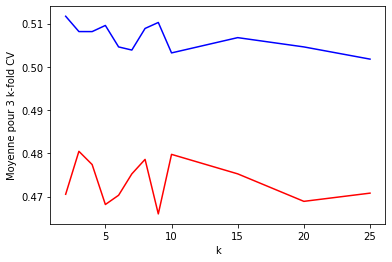

<Figure size 432x288 with 0 Axes>

In [ ]:
def mean_score(modèle, k, n):
    fluctuation = []
    for i in range(n):
        fluctuation.append(cross_val_score(modèle, X, Y, cv=k).mean())
    return np.mean(fluctuation)

a = [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25]
v = [np.array(mean_score(LogisticRegression(), k, 3)) for k in a]
u = [np.array(mean_score(RandomForestClassifier(), k, 3)) for k in a]
plt.figure()
plt.plot(a, v, '-b')
plt.plot(a, u, '-r')
plt.xlabel('k')
plt.ylabel('Moyenne pour 3 k-fold CV')
plt.figure()

On voit que la régression logistique est clairement meilleure. On n'arrive pas vraiment un obtenir un meilleur cross_val score que 51

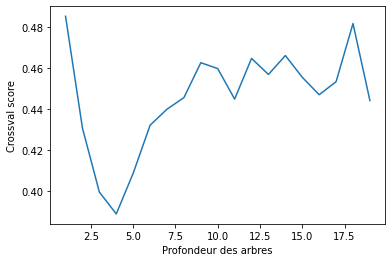

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
perf_dt = []
for i in range(1,20):
    clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=i))
    perf_dt.append(cross_val_score(clf, X, Y, cv=8).mean())
plt.figure()
plt.plot(np.arange(1, 20), perf_dt)
plt.xlabel('Profondeur des arbres')
plt.ylabel('Crossval score')
plt.show()

In [ ]:
AdaBoostClassifier().get_params()

{'algorithm': 'SAMME.R',
 'base_estimator': None,
 'learning_rate': 1.0,
 'n_estimators': 50,
 'random_state': None}

In [ ]:
from sklearn.linear_model import Lasso

param_grid = {'base_estimator': [DecisionTreeClassifier(), RandomForestClassifier(), LogisticRegression()],
             'learning_rate': [0.001, 0.01, 0.1, 1.0],
             'n_estimators': [50, 100, 150, 200]}

In [ ]:
from sklearn.model_selection import GridSearchCV

rg = GridSearchCV(AdaBoostClassifier(), param_grid=param_grid, scoring='r2')
rg.fit(X_train, Y_train) 


GridSearchCV(cv=None, error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=None,
                                          learning_rate=1.0, n_estimators=50,
                                          random_state=None),
             iid='deprecated', n_jobs=None,
             param_grid={'base_estimator': [DecisionTreeClassifier(ccp_alpha=0.0,
                                                                   class_weight=None,
                                                                   criterion='gini',
                                                                   max_depth=None,
                                                                   max_features=None,
                                                                   max_leaf_nodes=None,
                                                                   min_imp...
                                                               

In [ ]:
from sklearn.model_selection import GridSearchCV

rg2 = GridSearchCV(AdaBoostClassifier(), param_grid=param_grid, scoring='precision_macro')
rg2.fit(X_train, Y_train) 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Pr

GridSearchCV(cv=None, error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=None,
                                          learning_rate=1.0, n_estimators=50,
                                          random_state=None),
             iid='deprecated', n_jobs=None,
             param_grid={'base_estimator': [DecisionTreeClassifier(ccp_alpha=0.0,
                                                                   class_weight=None,
                                                                   criterion='gini',
                                                                   max_depth=None,
                                                                   max_features=None,
                                                                   max_leaf_nodes=None,
                                                                   min_imp...
                                                               

In [ ]:
results = pd.DataFrame(rg2.cv_results_)
results.sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_base_estimator,param_learning_rate,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
28,12.312393,0.058835,0.561979,0.009159,"RandomForestClassifier(bootstrap=True, ccp_alp...",1,50,{'base_estimator': RandomForestClassifier(boot...,0.440536,0.525248,0.434710,0.439348,0.430175,0.454003,0.035811,1
29,24.285175,0.115933,1.110947,0.006386,"RandomForestClassifier(bootstrap=True, ccp_alp...",1,100,{'base_estimator': RandomForestClassifier(boot...,0.430711,0.541540,0.428587,0.441911,0.417105,0.451971,0.045471,2
26,37.873227,0.190222,1.714855,0.058221,"RandomForestClassifier(bootstrap=True, ccp_alp...",0.1,150,{'base_estimator': RandomForestClassifier(boot...,0.406868,0.535029,0.448019,0.454552,0.399829,0.448859,0.048220,3
31,47.473931,1.215132,2.168575,0.033698,"RandomForestClassifier(bootstrap=True, ccp_alp...",1,200,{'base_estimator': RandomForestClassifier(boot...,0.407461,0.553310,0.431007,0.416420,0.435446,0.448729,0.053244,4
27,50.182207,0.118014,2.246752,0.010950,"RandomForestClassifier(bootstrap=True, ccp_alp...",0.1,200,{'base_estimator': RandomForestClassifier(boot...,0.424809,0.542185,0.438033,0.454552,0.383211,0.448558,0.052434,5
25,25.369102,0.139742,1.128532,0.006808,"RandomForestClassifier(bootstrap=True, ccp_alp...",0.1,100,{'base_estimator': RandomForestClassifier(boot...,0.416704,0.525460,0.453743,0.434169,0.396841,0.445383,0.044242,6
30,35.889686,0.654327,1.637794,0.018736,"RandomForestClassifier(bootstrap=True, ccp_alp...",1,150,{'base_estimator': RandomForestClassifier(boot...,0.395357,0.524070,0.434085,0.442973,0.430170,0.445331,0.042566,7
15,0.981562,0.009452,0.040696,0.000489,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",1,200,{'base_estimator': DecisionTreeClassifier(ccp_...,0.443748,0.482315,0.465333,0.382395,0.421069,0.438972,0.034979,8
24,12.971544,0.122869,0.568574,0.011373,"RandomForestClassifier(bootstrap=True, ccp_alp...",0.1,50,{'base_estimator': RandomForestClassifier(boot...,0.392949,0.505892,0.438033,0.427759,0.417414,0.436409,0.037828,9
16,12.435610,0.099247,0.553908,0.005835,"RandomForestClassifier(bootstrap=True, ccp_alp...",0.001,50,{'base_estimator': RandomForestClassifier(boot...,0.431918,0.466949,0.418153,0.427127,0.426796,0.434189,0.016971,10


In [ ]:


Y_pred = rg2.predict(X_test)
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.43      0.39      0.41       111
           1       0.27      0.06      0.09       125
           3       0.49      0.78      0.60       187

    accuracy                           0.46       423
   macro avg       0.39      0.41      0.37       423
weighted avg       0.41      0.46      0.40       423



In [ ]:
df_2020['DrawsHomeTeam'] = np.zeros(len(df_2020)) 
df_2020['DrawsAwayTeam'] = np.zeros(len(df_2020))

for team in df_2020.drop_duplicates(['HomeTeam'])['HomeTeam']: 
  
  average_draws_team = 0.29
  nb_matches = 1

  for k in range(len(df)): 

    if df_2020['HomeTeam'].iloc[k] == team : 
      
      df_2020['DrawsHomeTeam'].iloc[k] = average_draws_team
       
      r = float(df_2020['Result'].iloc[k]==1) # renvoie 1 si match nul, 0 sinon

      average_draws_team = (average_draws_team*nb_matches + r)/(nb_matches+1)
      
      nb_matches = nb_matches+1
    
    if df_2020['AwayTeam'].iloc[k] == team : 
      
      df_2020['DrawsAwayTeam'].iloc[k] = average_draws_team

      r = float(df_2020['Result'].iloc[k]==1)

      average_draws_team = (average_draws_team*nb_matches + r)/(nb_matches+1) 
      
      nb_matches = nb_matches+1

    if nb_matches >= 39 : 
      nb_matches = 1 

    
display(df_2020)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


IndexError: ignored

In [ ]:
df_2020_bet = df_2020

df_2020_bet['Prediction'] = rg2.predict(pd.DataFrame(np.c_[df_2020_bet['PtsHomeTeam'], df_2020_bet['PtsAwayTeam'], df_2020_bet['FormHomeTeam'], df_2020_bet['FormAwayTeam'], df_2020_bet['DrawsHomeTeam'], df_2020_bet['DrawsAwayTeam']])) # Nous créons une colonne de prédiction

# Nous définissons une fonction pour savoir quelle côte choisir pour chacun de nos paris.
# Par soucis de simplicité, nous n'allons regarder que les côtes du site de pari 365, réputé pour proposer les côtes les plus intéréssantes.
# Nous pourrons modifier ce détail par la suite.

df_2020_bet['Côte'] = np.zeros(len(df_2020_bet)) # On crée une colonne qui répértorie les côtes associées à nos paris, se remplissant au fur et à mesure.
df_2020_bet['Gains'] = np.zeros(len(df_2020_bet)) # On créée une colonne de gains

for k in range(len(df_2020_bet)) : # Nous remplissons les colonnes de côtes et gains au fur et à mesure. Nous aurions pu passer par un apply, mais nous tenions à réutiliser
# notre fonction resultat_pari définie au début.

  resultat_predit = df_2020_bet['Prediction'].iloc[k] 
  resultat_reel = df_2020_bet['Result'].iloc[k]

  if resultat_predit == 3:

    côte = df_2020_bet['B365H'].iloc[k]
    df_2020_bet['Côte'].iloc[k] = côte 

  elif resultat_predit == 1:

    côte = df_2020_bet['B365D'].iloc[k]
    df_2020_bet['Côte'].iloc[k] = côte

  elif resultat_predit == 0:

    côte = df_2020_bet['B365A'].iloc[k]
    df_2020_bet['Côte'].iloc[k] = côte
  
  df_2020_bet['Gains'].iloc[k] = resultat_pari(1, côte, resultat_predit, resultat_reel)


display(df_2020_bet[['HomeTeam', 'AwayTeam', 'Prediction', 'Côte', 'Result', 'Gains']])

In [ ]:
sum(df_2020_bet['Gains'].dropna())

In [ ]:
df_new = df_2020_bet[df_2020_bet['Prediction'] == 0]
sum(df_new[df_new['Côte'] > 2.2]['Gains'].dropna())

In [ ]:
sum(df_2020_bet[df_2020_bet['Prediction'] == 0]['Gains'].dropna())

In [ ]:
paris = rg.predict_proba(pd.DataFrame(np.c_[df_2020_bet['PtsHomeTeam'], df_2020_bet['PtsAwayTeam'], df_2020_bet['FormHomeTeam'], df_2020_bet['FormAwayTeam'], df_2020_bet['DrawsHomeTeam'], df_2020_bet['DrawsAwayTeam']]))
print(paris)

In [ ]:
def maximum(a,b,c):
  if a>b and a>c:
    return(a)
  elif b>c:
    return(b)
  else:
    return(c)

df_2020_bet['CôtePredictHome'] = np.zeros(len(df_2020_bet)) 
df_2020_bet['CôtePredictDraw'] = np.zeros(len(df_2020_bet)) 
df_2020_bet['CôtePredictAway'] = np.zeros(len(df_2020_bet))
df_2020_bet['Mise'] = np.zeros(len(df_2020_bet)) 


for k in range(len(df_2020_bet)) : 
  df_2020_bet['CôtePredictHome'].iloc[k] = 1/paris[k][0]
  df_2020_bet['CôtePredictDraw'].iloc[k] = 1/paris[k][1]
  df_2020_bet['CôtePredictAway'].iloc[k] = 1/paris[k][2]
  if df_2020_bet['B365H'].iloc[k]-df_2020_bet['CôtePredictHome'].iloc[k]>0 :
    pari = 1
  if df_2020_bet['B365D'].iloc[k]-df_2020_bet['CôtePredictDraw'].iloc[k]>0 :
    pari = 1
  if df_2020_bet['B365A'].iloc[k]-df_2020_bet['CôtePredictAway'].iloc[k]>0 :
    pari = 1
  if pari == 1 :
    df_2020_bet['Mise'].iloc[k]= 1
  else:
    df_2020_bet['Mise'].iloc[k]=0
  a=float(df_2020_bet['B365H'].iloc[k]-df_2020_bet['CôtePredictHome'].iloc[k])
  b=float(df_2020_bet['B365D'].iloc[k]-df_2020_bet['CôtePredictDraw'].iloc[k])
  c=float(df_2020_bet['B365A'].iloc[k]-df_2020_bet['CôtePredictAway'].iloc[k])

  m = maximum(a,b,c)
  if df_2020_bet['B365H'].iloc[k]-df_2020_bet['CôtePredictHome'].iloc[k] == m:
    df_2020_bet['Prediction'].iloc[k]= 3
  elif df_2020_bet['B365D'].iloc[k]-df_2020_bet['CôtePredictDraw'].iloc[k] == m:
    df_2020_bet['Prediction'].iloc[k]= 1
  else:
    df_2020_bet['Prediction'].iloc[k]= 0

    resultat_predit = df_2020_bet['Prediction'].iloc[k] 
  resultat_reel = df_2020_bet['Result'].iloc[k]

  if resultat_predit == 3:

    côte = df_2020_bet['B365H'].iloc[k]
    df_2020_bet['Côte'].iloc[k] = côte 

  elif resultat_predit == 1:

    côte = df_2020_bet['B365D'].iloc[k]
    df_2020_bet['Côte'].iloc[k] = côte

  elif resultat_predit == 0:

    côte = df_2020_bet['B365A'].iloc[k]
    df_2020_bet['Côte'].iloc[k] = côte
  
  df_2020_bet['Gains'].iloc[k] = resultat_pari(df_2020_bet['Mise'].iloc[k], côte, resultat_predit, resultat_reel)


display(display(df_2020_bet[['HomeTeam', 'AwayTeam', 'Prediction', 'Côte', 'Result', 'Gains', 'B365H', 'CôtePredictHome', 'B365D', 'CôtePredictDraw', 'B365A', 'CôtePredictAway']]))




In [ ]:
sum(df_2020_bet['Gains'].dropna())



In [ ]:
df_new = df_2020_bet[df_2020_bet['Prediction'] == 0]
sum(df_new[df_new['Côte'] > 2.2]['Gains'].dropna())

In [ ]:
sum(df_2020_bet[df_2020_bet['Prediction'] == 0]['Gains'].dropna())